NYC Open Data currently publishes the [NYPD Motor Vehicle Collisions - Crashes](https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions-Crashes/h9gi-nx95) data set that breaks down every automotive collision in NYC.  The purpose of the data set is for the public to understand how dangerous certain intersections are as well as the causes and outcomes of accidents.  Some of the data is incomplete, especially the more recent data points. Let's take a look at the data.

In [435]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings("ignore")

Crash_Data = pd.read_csv("NYPD_Motor_Vehicle_Collisions_-_Crashes.csv")

In [8]:
Crash_Data.shape

(1590661, 29)

We have a data set of 1.59 million accidents and 29 variables concerning each. Let's take a closer look at what the 29 variables in the data set are:

In [21]:
for i in Crash_Data.columns:
    print("|"+i[0].upper() + i[1:].lower()+"|  |")

|Date|  |
|Time|  |
|Borough|  |
|Zip code|  |
|Latitude|  |
|Longitude|  |
|Location|  |
|On street name|  |
|Cross street name|  |
|Off street name|  |
|Number of persons injured|  |
|Number of persons killed|  |
|Number of pedestrians injured|  |
|Number of pedestrians killed|  |
|Number of cyclist injured|  |
|Number of cyclist killed|  |
|Number of motorist injured|  |
|Number of motorist killed|  |
|Contributing factor vehicle 1|  |
|Contributing factor vehicle 2|  |
|Contributing factor vehicle 3|  |
|Contributing factor vehicle 4|  |
|Contributing factor vehicle 5|  |
|Collision_id|  |
|Vehicle type code 1|  |
|Vehicle type code 2|  |
|Vehicle type code 3|  |
|Vehicle type code 4|  |
|Vehicle type code 5|  |


|Variable   | Description   |
|:-:|:-:|
|Date|Occurrence date of collision  |
|Time|Occurrence time of collision  |
|Borough|Borough where collision occurred  |
|Zip code|Postal code of incident occurrence  |
|Latitude|Latitude coordinate  |
|Longitude|Longitude coordinate  |
|Location|Latitude, Longitude pair  |
|On street name|Street on which the collision occurred  |
|Cross street name|Nearest cross street to the collision  |
|Off street name|Street address if known  |
|Number of persons injured|Number of persons injured  |
|Number of persons killed|Number of persons killed  |
|Number of pedestrians injured|Number of pedestrians injured  |
|Number of pedestrians killed|Number of pedestrians killed  |
|Number of cyclist injured|Number of cyclists injured  |
|Number of cyclist killed|Number of cyclists killed  |
|Number of motorist injured|Number of vehicle occupants injured  |
|Number of motorist killed|Number of vehicle occupants killed  |
|Contributing factor vehicle 1|Factors contributing to the collision for designated vehicle  |
|Contributing factor vehicle 2|Factors contributing to the collision for designated vehicle  |
|Contributing factor vehicle 3|Factors contributing to the collision for designated vehicle  |
|Contributing factor vehicle 4|Factors contributing to the collision for designated vehicle  |
|Contributing factor vehicle 5|Factors contributing to the collision for designated vehicle  |
|Collision_id|Unique record code generated by system. Primary Key  |
|Vehicle type code 1|Type of vehicle based on the selected vehicle category  |
|Vehicle type code 2|Type of vehicle based on the selected vehicle category  |
|Vehicle type code 3|Type of vehicle based on the selected vehicle category  |
|Vehicle type code 4|Type of vehicle based on the selected vehicle category  |
|Vehicle type code 5|Type of vehicle based on the selected vehicle category  |

The vehicle type codes include ATVs, bicycles, cars or SUVs, E-Bikes, E-Scooters, trucks or buses, motorcycles, and other.  Not sure what other methods of transport people have in NYC. Longboards? Electric skateboards?
The descriptions in the table above came directly from NYC OpenData.  I have my doubts about the reports being consistent thorughout the city.

In [414]:
print(Crash_Data.groupby('VEHICLE TYPE CODE 1')['VEHICLE TYPE CODE 1'].count().sort_values(ascending=False)[0:30])
print("\nNumber of accidents above: "+ str(sum(Crash_Data.groupby('VEHICLE TYPE CODE 1')['VEHICLE TYPE CODE 1'].count().sort_values(ascending=False)[0:30])))

VEHICLE TYPE CODE 1
PASSENGER VEHICLE                      715236
SPORT UTILITY / STATION WAGON          313500
Sedan                                  149226
Station Wagon/Sport Utility Vehicle    120353
TAXI                                    50670
VAN                                     26540
OTHER                                   23982
PICK-UP TRUCK                           23069
UNKNOWN                                 19929
Taxi                                    15386
SMALL COM VEH(4 TIRES)                  14559
LARGE COM VEH(6 OR MORE TIRES)          14527
BUS                                     14057
LIVERY VEHICLE                          10481
Pick-up Truck                           10005
Box Truck                                7854
MOTORCYCLE                               6536
Bus                                      6431
BICYCLE                                  5568
Bike                                     3878
Tractor Truck Diesel                     3454
Van           

So that's a lot of in the "other" category.  It wouldn't be very practical to find every accident that involved a horse or a well driller.  There are actually 686 unique values in this column, so let's try to correct them in terms of frequency. 

The groups above make up 1.57 million of the accidents in our data set. For simplicity, we'll stick to these groups and attempt to narrow them down.  The groups we'll use are: 
* Car
* SUV
* Taxi
* Bus
* Commercial vehicle
* Bicycle 
* Motorcycle
* Pickup truck
* Van
* Commercial vehicle
* Other
* Unknown

In [436]:
Replacement_Type = {"PASSENGER VEHICLE":"Car", "SPORT UTILITY / STATION WAGON": "SUV",
                   "Sedan":"Car", "Station Wagon/Sport Utility Vehicle":"SUV", "TAXI": "Taxi","VAN":"Van",
                   "OTHER":"Other", "PICK-UP TRUCK": "Pick-up Truck", "SMALL COM VEH(4 TIRES)":"Commercial Vehicle",
                   "LARGE COM VEH(6 OR MORE TIRES)":"Commercial Vehicle", "BUS":"Bus", "LIVERY VEHICLE":"Taxi",
                   "Box Truck":"Commercial Vehicle","MOTORCYCLE":"Motorcycle","BICYCLE":"Bicycle","Bike":"Bicycle",
                   "Tractor Truck Diesel":"Commercial Vehicle","TK":"Commercial Vehicle","BU":"Other","Convertible":"Car",
                   "Dump":"Other","Ambulance":"Other"}

def Check_Replacement_Type(replacement_dict, current_value):
    try:
        if current_value in replacement_dict:
            return replacement_dict.get(current_value)
    except KeyError:
        return None

Crash_Data['VEHICLE TYPE CODE 1'] = Crash_Data['VEHICLE TYPE CODE 1'].apply(lambda x: Check_Replacement_Type(Replacement_Type, x))

Crash_Data['VEHICLE TYPE CODE 1'] = Crash_Data['VEHICLE TYPE CODE 1'].dropna()

Crash_Data = Crash_Data.reset_index(drop=True)

In the code above, we defined a dictionary containing a list of substitutions for the original vehicle types.  Some of the types repeat but come up as unique due to spelling differences.

The function `Check_Replacement_Type` is used to compare the values in the dateframe to those in the dictionary.  It's much faster to create a function and apply it as opposed to just looping over the array.  Anything that wasn't in the dictionary was then dropped, leaving us with about 1.49 million accidents, which is more than enough.  The last line resets the index of the dateframe to account for the dropped values.

Looking at the same column again, things seem a bit more orderly.

In [416]:
print(Crash_Data.groupby('VEHICLE TYPE CODE 1')['VEHICLE TYPE CODE 1'].count().sort_values(ascending=False))
print("\nNumber of accidents with 1 vehicle: "+ str(sum(Crash_Data.groupby('VEHICLE TYPE CODE 1')['VEHICLE TYPE CODE 1'].count().sort_values(ascending=False))))

VEHICLE TYPE CODE 1
Car                   865774
SUV                   433853
Taxi                   61151
Commercial Vehicle     28320
Other                  28303
Van                    26540
Pick-up Truck          23069
Bus                    14057
Bicycle                 9446
Motorcycle              6536
Name: VEHICLE TYPE CODE 1, dtype: int64

Number of accidents with 1 vehicle: 1497049


We'll repeat a similar method for the other vehicle code columns, without dropping them.  Not every accident will have two or more cars, but it would be interesting to look it if it does.

In [437]:
for i in range(2,6):
    Crash_Data['VEHICLE TYPE CODE ' + str(i)] = Crash_Data['VEHICLE TYPE CODE ' + str(i)].apply(lambda x: Check_Replacement_Type(Replacement_Type, x))
    print(Crash_Data.groupby('VEHICLE TYPE CODE ' + str(i))['VEHICLE TYPE CODE ' + str(i)].count().sort_values(ascending=False))
    print("\nNumber of accidents with " + str(i) + " vehicles: "+ str(sum(Crash_Data.groupby('VEHICLE TYPE CODE '+str(i))['VEHICLE TYPE CODE '+str(i)].count().sort_values(ascending=False))))
    print("\n")

VEHICLE TYPE CODE 2
Car                   649765
SUV                   331572
Taxi                   50434
Bicycle                33537
Other                  29436
Commercial Vehicle     27984
Van                    24397
Pick-up Truck          21542
Bus                    11558
Motorcycle              5963
Name: VEHICLE TYPE CODE 2, dtype: int64

Number of accidents with 2 vehicles: 1186188


VEHICLE TYPE CODE 3
Car                   73813
SUV                   41492
Taxi                   3642
Pick-up Truck          2292
Van                    1489
Other                  1198
Commercial Vehicle      796
Bicycle                 623
Motorcycle              464
Bus                     403
Name: VEHICLE TYPE CODE 3, dtype: int64

Number of accidents with 3 vehicles: 126212


VEHICLE TYPE CODE 4
Car                   26990
SUV                   16132
Taxi                   1735
Pick-up Truck          1289
Bicycle                1066
Van                     319
Motorcycle              258

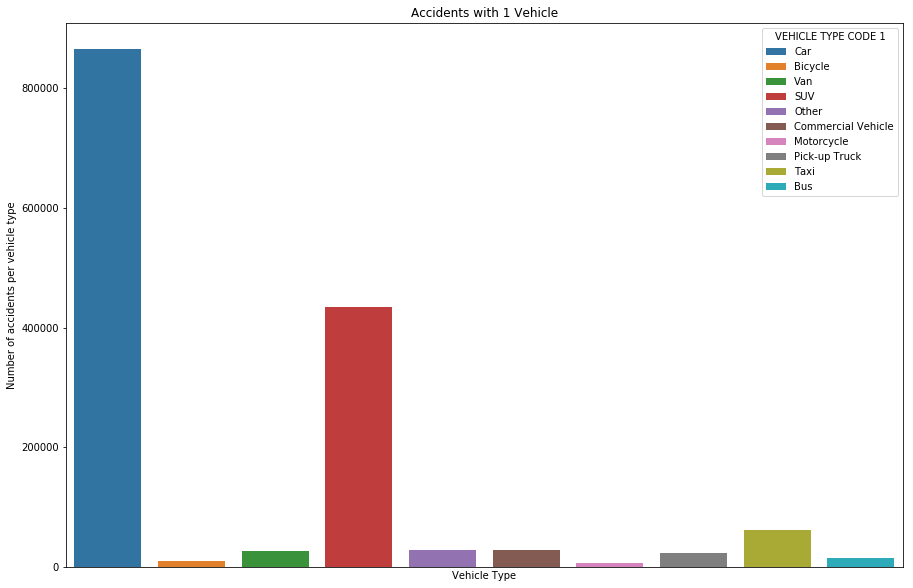

In [274]:
plt.figure(figsize=(15,10))

plot1 = sns.countplot(x='VEHICLE TYPE CODE 1', data=Crash_Data, hue=Crash_Data['VEHICLE TYPE CODE 1'],dodge=False)
plot1.set_title("Accidents with 1 Vehicle")
plot1.set_ylabel("Number of accidents per vehicle type")
plot1.set_xlabel("Vehicle Type")
plt.xticks([])
plt.show()

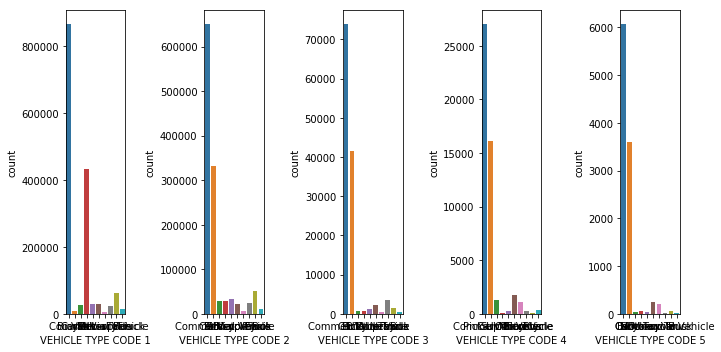

In [322]:
fig, (axis1, axis2, axis3, axis4, axis5) = plt.subplots(nrows=1,ncols=5,figsize=(10,5))

plot1=sns.countplot(x='VEHICLE TYPE CODE 1', data=Crash_Data, ax=axis1)


plot2=sns.countplot(x='VEHICLE TYPE CODE 2', data=Crash_Data, ax=axis2)

plot3=sns.countplot(x='VEHICLE TYPE CODE 3', data=Crash_Data, ax=axis3)

plot4=sns.countplot(x='VEHICLE TYPE CODE 4', data=Crash_Data, ax=axis4)

plot5=sns.countplot(x='VEHICLE TYPE CODE 5', data=Crash_Data, ax=axis5)
plt.tight_layout()

Where are the accidents happening the most? A simple bar chart shows the following:

BOROUGH
BROOKLYN         344341
QUEENS           295118
MANHATTAN        266914
BRONX            154368
STATEN ISLAND     48280
Name: BOROUGH, dtype: int64


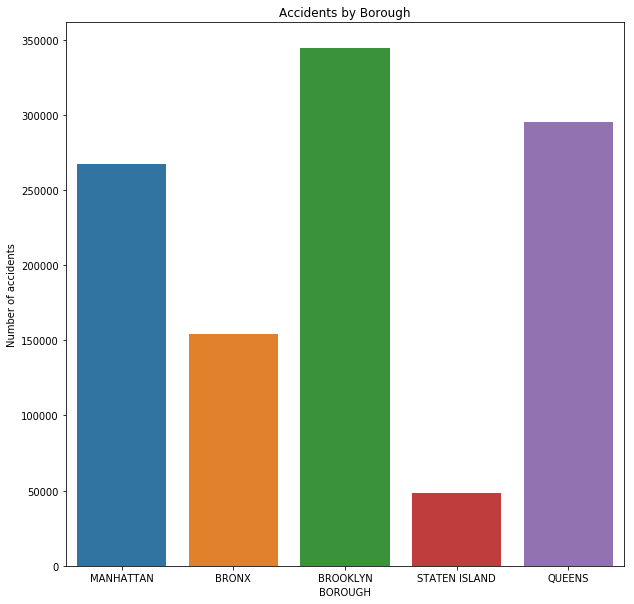

In [418]:
print(Crash_Data.groupby('BOROUGH')['BOROUGH'].count().sort_values(ascending=False))

plt.figure(figsize=(10,10))
plot2 = sns.countplot(x="BOROUGH", data=Crash_Data)
plot2.set_title("Accidents by Borough")
plot2.set_ylabel("Number of accidents")
plt.show()

It looks like Brooklyn has the highest frequency, but we'll come back to geographic distribution of accidents later.
Now let's look at the most common reasons accidents occur.

In [419]:
print(Crash_Data.groupby('CONTRIBUTING FACTOR VEHICLE 1')['CONTRIBUTING FACTOR VEHICLE 1'].count().sort_values(ascending=False))

CONTRIBUTING FACTOR VEHICLE 1
Unspecified                                              586785
Driver Inattention/Distraction                           294720
Failure to Yield Right-of-Way                             90150
Following Too Closely                                     78557
Backing Unsafely                                          60792
Other Vehicular                                           50606
Fatigued/Drowsy                                           46841
Turning Improperly                                        40745
Passing or Lane Usage Improper                            37061
Passing Too Closely                                       33947
Unsafe Lane Changing                                      30130
Traffic Control Disregarded                               24252
Driver Inexperience                                       23360
Lost Consciousness                                        19611
Pavement Slippery                                         15742
Prescripti

In terms of cleanliness of the data, this column is much better compared to the vehicle type column.  A similar approach will be taken in terms of grouping, but the rows won't be dropped if blank.  The accident occurred, so it should be considered.

In [438]:
for i in range(1,6):
    Crash_Data['CONTRIBUTING FACTOR VEHICLE ' + str(i)] = Crash_Data['CONTRIBUTING FACTOR VEHICLE ' + str(i)].apply(lambda x: str(x).lower())
    Crash_Data['CONTRIBUTING FACTOR VEHICLE ' + str(i)] = Crash_Data['CONTRIBUTING FACTOR VEHICLE ' + str(i)].replace(['80','1'],'unspecified')
    Crash_Data['CONTRIBUTING FACTOR VEHICLE ' + str(i)] = Crash_Data['CONTRIBUTING FACTOR VEHICLE ' + str(i)].replace(['illnes'],'illness')

print(Crash_Data.groupby('CONTRIBUTING FACTOR VEHICLE 1')['CONTRIBUTING FACTOR VEHICLE 1'].count().sort_values(ascending=False))

CONTRIBUTING FACTOR VEHICLE 1
unspecified                                              586896
driver inattention/distraction                           294720
failure to yield right-of-way                             90150
following too closely                                     78557
backing unsafely                                          60792
other vehicular                                           50606
fatigued/drowsy                                           46841
turning improperly                                        40745
passing or lane usage improper                            37061
passing too closely                                       33947
unsafe lane changing                                      30130
traffic control disregarded                               24252
driver inexperience                                       23360
lost consciousness                                        19611
pavement slippery                                         15742
prescripti

Though slightly different than the approach used for replacing vehicle types, using numpy's built in `replace` method is pretty fast as well. It's also easier than making a dictionary.

Instead of just looking at the data in terms of its variables, it can also be analyzed as a time series.

In [441]:
import datetime as dt
Crash_Data["DATE"] = Crash_Data["DATE"].apply(lambda x: dt.datetime.strptime(x,'%m/%d/%Y').date())

In [451]:
Crash_Data_TS = pd.DataFrame(Crash_Data["DATE"])

In [449]:
Crash_Data_TS.set_index('DATE')

""
DATE
2019-10-20
2019-10-20
2019-10-20
2016-07-01
2019-10-20
2019-10-20
2019-10-19
2019-10-19
2019-10-19


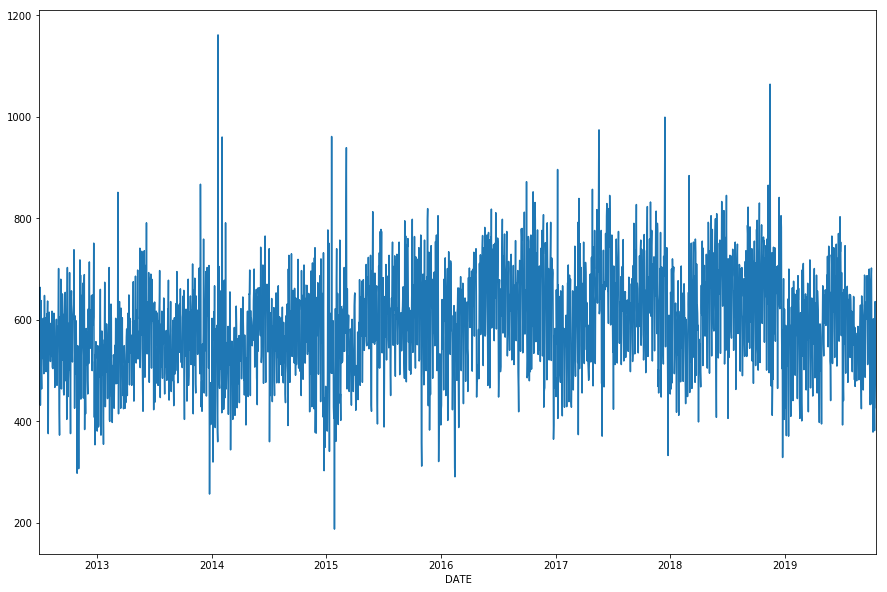

In [462]:
plt.figure(figsize=(15,10))
Crash_Data_TS.groupby("DATE")["DATE"].count().plot()